In [84]:
import pickle
import os.path as osp

import numpy as np
import transforms3d

from functools import partial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pycpd import affine_registration
from pycpd import deformable_registration
import numpy as np
import time

%matplotlib notebook

In [85]:
# Import data
DATA_PKL = "/home/rjulian/Downloads/data.pkl"
robot_data = pickle.load(open(DATA_PKL, "rb"))

In [86]:
def visualize(iteration, error, X, Y, ax):
    plt.cla()
    ax.scatter(X[:,0],  X[:,1], X[:,2], color='red', label='Target')
    ax.scatter(Y[:,0],  Y[:,1], Y[:,2], color='blue', label='Source')
    ax.text2D(0.87, 0.92, 'Iteration: {:d}\nError: {:06.4f}'.format(iteration, error), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize='x-large')
    ax.legend(loc='upper left', fontsize='x-large')
    plt.draw()

<IPython.core.display.Javascript object>


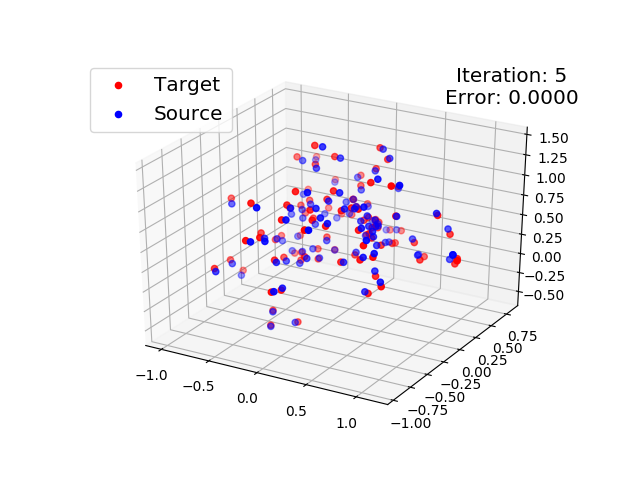

In [94]:
X = robot_data['points_gazebo']
Y= robot_data['points_mujoco']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
callback = partial(visualize, ax=ax)

reg = deformable_registration(**{ 'X': X, 'Y': Y }, tolerance=1e-5)
reg.register(callback)
plt.show()

In [88]:
# B, t = reg.get_registration_parameters()
# print(B)
# print(t)
# U, S, V = np.linalg.svd(B)
# print(S)
# print(1/S)
# print(t)

[[1.         0.82970646 0.98766    ... 0.95328063 0.83612519 0.60545623]
 [0.82970646 1.         0.77623504 ... 0.95448496 0.80642163 0.69360439]
 [0.98766    0.77623504 1.         ... 0.91491936 0.86122322 0.63712482]
 ...
 [0.95328063 0.95448496 0.91491936 ... 1.         0.84901914 0.67096248]
 [0.83612519 0.80642163 0.86122322 ... 0.84901914 1.         0.89247699]
 [0.60545623 0.69360439 0.63712482 ... 0.67096248 0.89247699 1.        ]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0.

In [96]:
mujoco_pt = robot_data['points_mujoco'][0]
gazebo_pt = robot_data['points_gazebo'][0]
print(mujoco_pt)
print(gazebo_pt)

maybe_gazebo_pt = reg.transform_point_cloud(mujoco_pt)[0]
print()
err_cal = np.linalg.norm(maybe_gazebo_pt - gazebo_pt)
print(err_cal)
err_orig = np.linalg.norm(mujoco_pt - gazebo_pt)
print(err_orig)

[0.41559475 0.24493949 0.27692916]
[0.43456105 0.25570767 0.28443383]

0.10159212792153006
0.023065004836148897


In [98]:

import numpy as np
from sklearn.neighbors import NearestNeighbors


def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i

In [112]:
T, d, i = icp(Y, X, tolerance=1e-10)
print(T)
print(i)

[[ 0.99997751  0.00408285  0.00532147 -0.00457096]
 [-0.00405511  0.99997819 -0.00521237  0.00312237]
 [-0.00534264  0.00519067  0.99997226 -0.00134439]
 [ 0.          0.          0.          1.        ]]
3


In [102]:
mujoco_pt = robot_data['points_mujoco'][0]
gazebo_pt = robot_data['points_gazebo'][0]
print(mujoco_pt)
print(gazebo_pt)

maybe_gazebo_pt = reg.transform_point_cloud(mujoco_pt)[0]
print()
err_cal = np.linalg.norm(maybe_gazebo_pt - gazebo_pt)
print(err_cal)
err_orig = np.linalg.norm(mujoco_pt - gazebo_pt)
print(err_orig)

array([[ 0.99997751,  0.00408285,  0.00532147, -0.00457096],
       [-0.00405511,  0.99997819, -0.00521237,  0.00312237],
       [-0.00534264,  0.00519067,  0.99997226, -0.00134439],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])